In [11]:
import imp
import os

import pandas as pd
import plotly.graph_objects as go
import plotly.express as px
import plotly

from BuildingControlSimulator.Simulator.Simulation import Simulation
from BuildingControlSimulator.BuildingModels.IDFPreprocessor import IDFPreprocessor
from BuildingControlSimulator.BuildingModels.EnergyPlusBuildingModel import EnergyPlusBuildingModel
from BuildingControlSimulator.ControlModels.Deadband import Deadband

plotly.offline.init_notebook_mode(connected=True)

In [12]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
s = Simulation(
    building_model=EnergyPlusBuildingModel(
        idf=IDFPreprocessor(
            idf_name=f"Zone5VAV-Pri-SecLoop_{os.environ['ENERGYPLUS_INSTALL_VERSION']}.idf",
            init_temperature=21.),
        weather_name="USA_IL_Chicago-OHare.Intl.AP.725300_TMY3.epw"
    ),
    controller=Deadband(deadband=1., stp_heat=21., stp_cool=25.),
    step_size_minutes=5,
    start_time_days = 200,
    final_time_days = 203,
)

IDFPreprocessor loading .idf file: /root/home/lib/building-control-simulator/idf/v8-9-0/Zone5VAV-Pri-SecLoop_8-9-0.idf


In [14]:
s.initialize()

Model init starting ...
Complete.


In [15]:
df = s.run()

Running co-simulation loop...
Co-simulation finished.


In [16]:
df["FMU_Main_Chiller_Chiller_Electric_Power"].max()

7586.227479188601

In [17]:
df["total_heating"] = (df["FMU_SPACE5_1_Zone_Air_System_Sensible_Heating_Rate"] 
                    + df["FMU_SPACE4_1_Zone_Air_System_Sensible_Heating_Rate"]
                    + df["FMU_SPACE3_1_Zone_Air_System_Sensible_Heating_Rate"]
                    + df["FMU_SPACE2_1_Zone_Air_System_Sensible_Heating_Rate"]
                    + df["FMU_SPACE1_1_Zone_Air_System_Sensible_Heating_Rate"])
df["total_cooling"] = (df["FMU_SPACE5_1_Zone_Air_System_Sensible_Cooling_Rate"] 
                    + df["FMU_SPACE4_1_Zone_Air_System_Sensible_Cooling_Rate"]
                    + df["FMU_SPACE3_1_Zone_Air_System_Sensible_Cooling_Rate"]
                    + df["FMU_SPACE2_1_Zone_Air_System_Sensible_Cooling_Rate"]
                    + df["FMU_SPACE1_1_Zone_Air_System_Sensible_Cooling_Rate"])

In [18]:
df["total_internal_heat"] = (df["FMU_SPACE5_1_Zone_Total_Internal_Total_Heating_Rate"] 
                    + df["FMU_SPACE4_1_Zone_Total_Internal_Total_Heating_Rate"]
                    + df["FMU_SPACE3_1_Zone_Total_Internal_Total_Heating_Rate"]
                    + df["FMU_SPACE2_1_Zone_Total_Internal_Total_Heating_Rate"]
                    + df["FMU_SPACE1_1_Zone_Total_Internal_Total_Heating_Rate"])

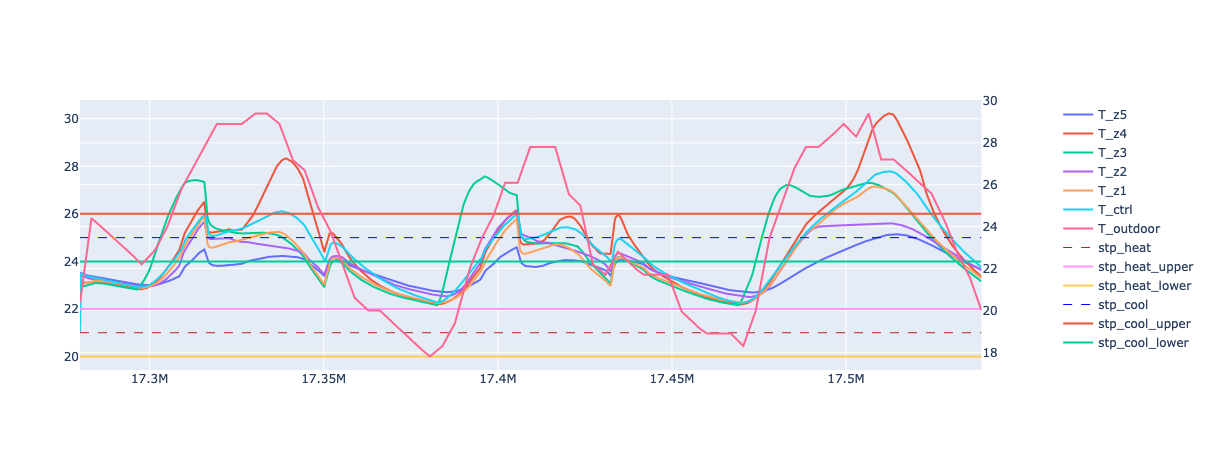

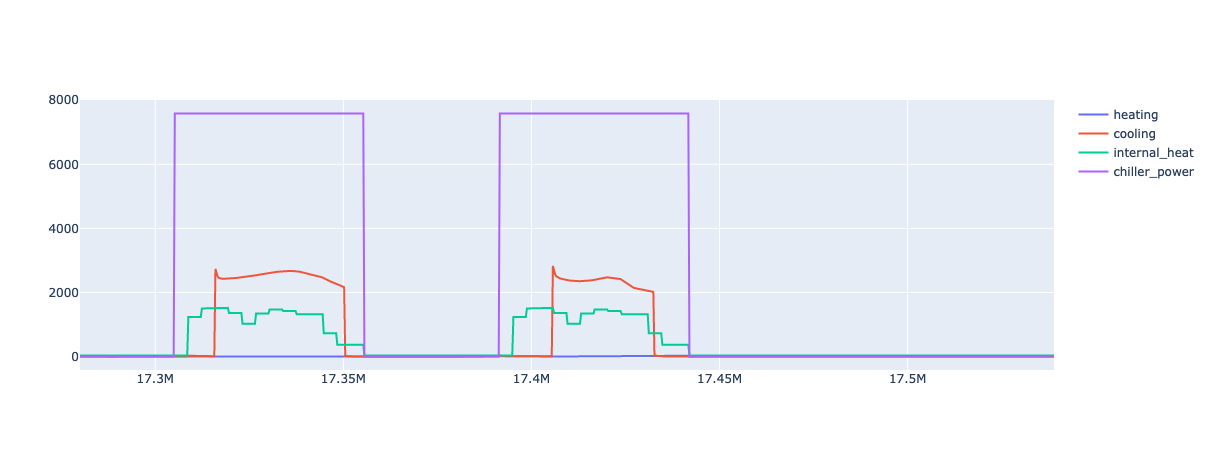

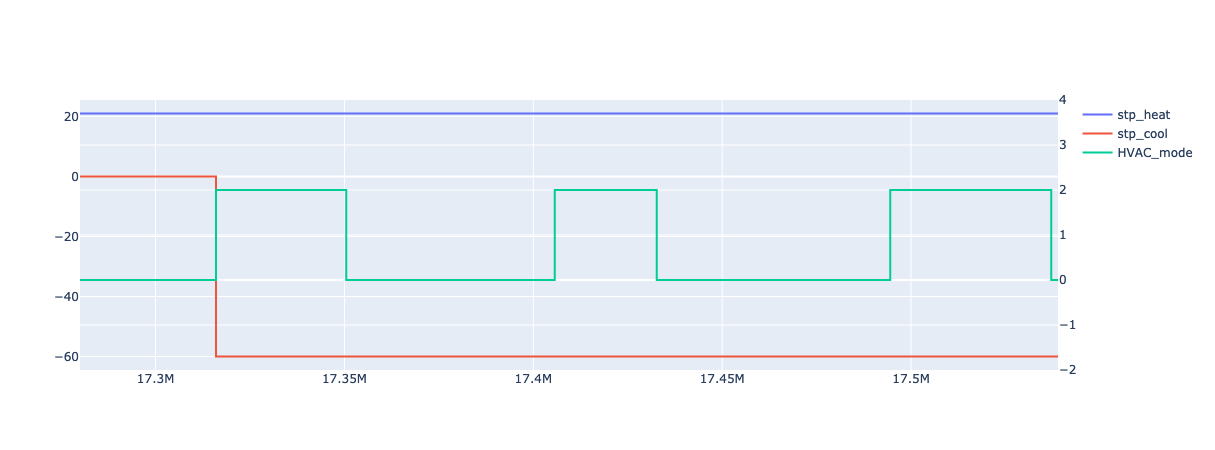

In [19]:
fig = plotly.subplots.make_subplots(rows=1, cols=1, specs=[[{"secondary_y": True}]])

fig.add_trace(go.Scatter(x=df.time_seconds, y=df["FMU_SPACE5_1_Zone_Air_Temperature"], mode='lines',name='T_z5'), row=1, col=1, secondary_y=False)
fig.add_trace(go.Scatter(x=df.time_seconds, y=df["FMU_SPACE4_1_Zone_Air_Temperature"], mode='lines',name='T_z4'), row=1, col=1, secondary_y=False)
fig.add_trace(go.Scatter(x=df.time_seconds, y=df["FMU_SPACE3_1_Zone_Air_Temperature"], mode='lines',name='T_z3'), row=1, col=1, secondary_y=False)
fig.add_trace(go.Scatter(x=df.time_seconds, y=df["FMU_SPACE2_1_Zone_Air_Temperature"], mode='lines',name='T_z2'), row=1, col=1, secondary_y=False)
fig.add_trace(go.Scatter(x=df.time_seconds, y=df["FMU_SPACE1_1_Zone_Air_Temperature"], mode='lines',name='T_z1'), row=1, col=1, secondary_y=False)
fig.add_trace(go.Scatter(x=df.time_seconds, y=df["t_ctrl"], mode='lines',name='T_ctrl'), row=1, col=1, secondary_y=False)

fig.add_trace(go.Scatter(
    x=df.time_seconds, y=df["FMU_Environment_Site_Outdoor_Air_Drybulb_Temperature"], mode='lines',name='T_outdoor')
              , row=1, col=1, secondary_y=True)

fig.add_trace(go.Scatter(x=df.time_seconds, y=df["stp_heat"],
                         mode='lines',
                         line=dict(color='firebrick', width=1,dash='dash'),
                         name='stp_heat'), row=1, col=1, secondary_y=False)
fig.add_trace(go.Scatter(x=df.time_seconds, y=df["stp_heat"] + df["deadband"], mode='lines',name='stp_heat_upper'), row=1, col=1, secondary_y=False)
fig.add_trace(go.Scatter(x=df.time_seconds, y=df["stp_heat"] - df["deadband"], mode='lines',name='stp_heat_lower'), row=1, col=1, secondary_y=False)

fig.add_trace(go.Scatter(x=df.time_seconds, y=df["stp_cool"],
                         mode='lines',
                         line=dict(color='blue', width=1,dash='dash'),
                         name='stp_cool'), row=1, col=1, secondary_y=False)
fig.add_trace(go.Scatter(x=df.time_seconds, y=df["stp_cool"] + df["deadband"], mode='lines',name='stp_cool_upper'), row=1, col=1, secondary_y=False)
fig.add_trace(go.Scatter(x=df.time_seconds, y=df["stp_cool"] - df["deadband"], mode='lines',name='stp_cool_lower'), row=1, col=1, secondary_y=False)

fig.show()

fig = plotly.subplots.make_subplots(rows=1, cols=1)
fig.add_trace(go.Scatter(x=df.time_seconds, y=df["total_heating"], mode='lines',name='heating'), row=1, col=1)
fig.add_trace(go.Scatter(x=df.time_seconds, y=df["total_cooling"], mode='lines',name='cooling'), row=1, col=1)
fig.add_trace(go.Scatter(x=df.time_seconds, y=df["total_internal_heat"], mode='lines',name='internal_heat'), row=1, col=1)
fig.add_trace(go.Scatter(x=df.time_seconds, y=df["FMU_Main_Chiller_Chiller_Electric_Power"], mode='lines',name='chiller_power'), row=1, col=1)


fig.show()
layout = go.Layout(yaxis2=dict(
    range=[-2, 4],
    overlaying='y',
    side='right'
))
traces = []
traces.append(go.Scatter(x=df.time_seconds, y=df["FMU_SPACE1_1_Zone_Thermostat_Heating_Setpoint_Temperature"], mode='lines', line_shape='hv', name='stp_heat'))
traces.append(go.Scatter(x=df.time_seconds, y=df["FMU_SPACE1_1_Zone_Thermostat_Cooling_Setpoint_Temperature"], mode='lines', line_shape='hv', name='stp_cool'))
traces.append(go.Scatter(x=df.time_seconds, y=df["HVAC_mode"], mode='lines', line_shape='hv', name='HVAC_mode', yaxis="y2"))

fig = go.Figure(data=traces, layout=layout)
# fig.add_trace(data, row=1, col=1, secondary_y=True, layout=layout)
fig.show()
# fig.update_layout(height=800, width=1000, title_text="Simulation results")